In [1]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd

import sys
sys.path.insert(0, '../../')
from analysis.model_performances import * #gather_questions, TRANSPORTATION_DOMAINS, NON_TRANSPORTATION_DOMAINS
from common import *
import pandas as pd

In [2]:
instances_id_ls = [f'Instance_{i}' for i in range(1, 5)]
prob_of_getting_none = 0.05

In [3]:
def is_good_qa(question_info, include_params, exclude_params):
    for k, v in exclude_params.items():
        if question_info[k] == v:
            return False
        
    for k, v in include_params.items():
        if question_info[k] != v:
            return False
    return True

def tokens_in_text(text, chars_per_token=4):
    return len(text)/chars_per_token


def sample_data(data_all, questions_by_id, selected_plan_length, instances_id_ls):
    selected_data = []
    exclude_params = {}
    include_params = {'plan_length': selected_plan_length}
    for d in data_all:
        if d[OUT_OBJ_INSTANCE_ID] not in instances_id_ls:
            continue
        question_id = d[OUT_OBJ_ID]
        if question_id not in questions_by_id:
            raise ValueError
        question_info = questions_by_id[question_id]
        if is_good_qa(question_info, include_params, exclude_params):
            selected_data.append(d)
    random.shuffle(selected_data)
    return selected_data

def output_keys(questions_dict):
    q = questions_dict
    key1 = q[OUT_OBJ_QUESTION_CATEGORY]
    if q[OUT_OBJ_ANSWER_TYPE] == TRUE_FALSE_ANSWER_TYPE:
        if q[OUT_OBJ_ANSWER] == 'True':
            key2 = 'true'
        else:
            key2 = 'false'
    else:
        key2 = 'free'
        
    key3 = q[OUT_OBJ_FLUENT_TYPE]
        
    if q[OUT_OBJ_IS_POS_FLUENT_QUESTION] == POS_FLUENTS_QUESTION:
        key4 = 'POS'
    elif q[OUT_OBJ_IS_POS_FLUENT_QUESTION] == NEG_FLUENTS_QUESTION:
        key4 = 'NEG'
    else:
        key4 = 'POS+NEG'
        
    if q[OUT_OBJ_DOMAIN_NAME] in TRANSPORTATION_DOMAINS:
        key5 = TRANSPORTATION_DOMAIN_KEY
    else:
        key5 = NON_TRANSPORTATION_DOMAIN_KEY
    return key1, key2, key3, key4, key5



def filter_by_length(questions_by_id, cutoff):
    ids_filtered = []
    for id, d in tqdm(questions_by_id.items()):
        max_len = 0
        for subs in [WITH_RANDOM_SUB, WITHOUT_RANDOM_SUB]:
            if subs not in d:
                continue
            q_dict = d[subs]
            max_len = max(max_len, tokens_in_text(q_dict[OUT_OBJ_QUESTION] + q_dict[OUT_OBJ_ANSWER]))
        if max_len <= cutoff:
            ids_filtered.append(id)
    return ids_filtered
 

In [4]:
questions_dir = f'{DATA_PATH}/questions'
questions_by_id = gather_questions_old_format(questions_dir)

questions gathered


# Data Stats

In [5]:
qa_len_ls = []
for q_id, d in questions_by_id.items():
    d_sub_type = d[WITHOUT_RANDOM_SUB]
    qa_len_ls.append(len(d_sub_type[OUT_OBJ_QUESTION] + d_sub_type[OUT_OBJ_ANSWER]))

(0.0, 39918.16951087397)

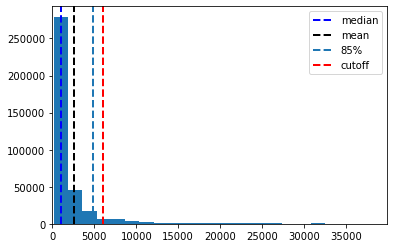

In [6]:
stats = {}
stats['mean'] = np.mean(qa_len_ls)
stats['median'] = np.median(qa_len_ls)
stats['std'] = np.std(qa_len_ls)
stats['min'] = np.min(qa_len_ls)
stats['max'] = np.max(qa_len_ls)

CUTOFF_CHAR_LEN = 1500*4 #(-stats['mean']*np.log(1-0.85))

plt.hist(qa_len_ls, bins=200)
plt.axvline(x=stats['median'], color='blue', linestyle='--', linewidth=2, label='median')
plt.axvline(x=stats['mean'], color='black', linestyle='--', linewidth=2, label='mean')
plt.axvline(x=(-stats['mean']*np.log(1-0.85)), linestyle='--', linewidth=2, label='85%')
plt.axvline(x=CUTOFF_CHAR_LEN, color='r', linestyle='--', linewidth=2, label='cutoff')
plt.legend()
plt.xlim(0, stats['mean']+4*stats['std'])

In [7]:
CUTOFF_CHAR_LEN/4

1500.0


# Filter

In [8]:
#TODO
# split by Instance 1-5 "instance in domain", 6-10 "instance out of domain" TRAIN
# Insure not a lot of Nones
def keep_some_nones(questions_by_id, ids_filtered, cutoff_prob):
    result_ids = []
    for k in ids_filtered:
        q = questions_by_id[k][WITHOUT_RANDOM_SUB]
        if q[OUT_OBJ_ANSWER] == 'None' and random.random() >= cutoff_prob:
                continue
        result_ids.append(k)
    return result_ids

def none_frequency(questions_no_sub_by_id):
    total = 0
    none = 0
    for k, q in questions_no_sub_by_id.items():
        # q = d[WITHOUT_RANDOM_SUB]
        if q[OUT_OBJ_ANSWER_TYPE] == FREE_ANSWER_TYPE:
            total += 1
        if q[OUT_OBJ_ANSWER] == 'None':
            none += 1
    return none/total

ids_filtered1 = filter_by_length(questions_by_id, CUTOFF_CHAR_LEN)

none_freq = none_frequency({id: questions_by_id[id][WITHOUT_RANDOM_SUB] for id in ids_filtered1})
ids_filtered2 = keep_some_nones(questions_by_id, ids_filtered1, prob_of_getting_none/(none_freq*2.5))
# ids_filtered2 = ids_filtered1
save_jsonl(ids_filtered2, 'filtered_ids.jsonl')

questions_no_sub_by_id = {id: questions_by_id[id][WITHOUT_RANDOM_SUB] for id in ids_filtered2}
data_domain_all = {domain: [d for d in questions_no_sub_by_id.values() if d[OUT_OBJ_DOMAIN_NAME] == domain] for domain in DOMAIN_NAMES}

100%|██████████| 372506/372506 [00:01<00:00, 225976.77it/s]


In [9]:
none_frequency(questions_no_sub_by_id)

0.021115305042720193

# Sample

In [93]:
def is_restricted(key1, key2, key3, key4):
    if key1 == 'fluent_tracking' and key2 != 'free' and key4 == 'POS+NEG':
        return True
    # if key1 == 'effects' and key2 == 'free' and not (key3 == FLUENT_TYPES_ALL and key4 == 'POS+NEG'):
    #     return True
    # if key1 == 'state_tracking' and key2 == 'free' and not (key3 == FLUENT_TYPES_ALL and key4 == 'POS+NEG'):
    #     return True
    return False   

def sample_test_data(data_domain_all, questions_no_sub_by_id, selected_plan_length, instances_id_ls):
    MAX_PER_CATEGORY = 12 #12 #110 # 100 #100
        
    # PREPARE DATA
    data_domain_sample = {domain: sample_data(data_domain_all[domain], questions_no_sub_by_id, selected_plan_length, instances_id_ls) for domain in DOMAIN_NAMES}
    # for k,v in data_domain_sample.items():
    #     print(k, len(v))
    min_samples = min([len(v) for v in data_domain_sample.values() if len(v) > 100])
    data_all = []
    for k, v in data_domain_sample.items():
        data_all.extend(v[:min_samples])
    random.shuffle(data_all)
    
    
    selected_ids = []
    data_by_category = defaultdict(list)
    for d in data_all:
        question_id = d[OUT_OBJ_ID]
        q = questions_no_sub_by_id[question_id]
        
        key1, key2, key3, key4, key5 = output_keys(q)
        key_all = (key1, key2, key3, key4, key5)
        if is_restricted(key1, key2, key3, key4):
            continue
        max_per_category = MAX_PER_CATEGORY
        if key2 == 'free':
            max_per_category = 3*MAX_PER_CATEGORY
            # if q[OUT_OBJ_ANSWER] == 'None':
            #     if random.random() > prob_of_getting_none:
            #         continue

        if key1 == 'action_executability':
            if key2 != 'free':
                max_per_category = 3.6*MAX_PER_CATEGORY

        if key1 == 'effects':
            if key2 != 'free':
                max_per_category = 5*MAX_PER_CATEGORY
            else:
                max_per_category = MAX_PER_CATEGORY

        if key1 == 'fluent_tracking':
            if key2 != 'free':
                max_per_category = MAX_PER_CATEGORY/2.4
            else:
                max_per_category = MAX_PER_CATEGORY

        if key1 == 'composite':
            if key2 != 'free':
                max_per_category = MAX_PER_CATEGORY*2.5
            else:
                max_per_category = MAX_PER_CATEGORY*15
            
            if key3 == BASE_FLUENTS:
                max_per_category = max_per_category*10
            
            if key3 == PERSISTENT_FLUENTS:
                max_per_category = max_per_category/1.4

        if key1 == 'state_tracking':
            if key2 == 'free':
                max_per_category = MAX_PER_CATEGORY
                

            
        if len(data_by_category[key_all]) < max_per_category:
            data_by_category[key_all].append(question_id)
    selected_ids.extend(list(itertools.chain.from_iterable(data_by_category.values())))
    
    return selected_ids

In [94]:
# selected_plan_length = 19
final_test_ids = []
for selected_plan_length in [1,10,19]:
    ids = sample_test_data(data_domain_all, questions_no_sub_by_id, selected_plan_length, instances_id_ls)
    print(len(ids))
    final_test_ids.extend(ids)
    
none_freq = none_frequency({id: questions_by_id[id][WITHOUT_RANDOM_SUB] for id in final_test_ids})
final_test_ids = keep_some_nones(questions_by_id, final_test_ids, prob_of_getting_none/(none_freq*1.1))
print(none_frequency({id: questions_by_id[id][WITHOUT_RANDOM_SUB] for id in final_test_ids}))

1754
1738
1759
0.04441702652683529


In [95]:
# by_domain = defaultdict(int)
# for id in final_test_ids:
#     q = questions_no_sub_by_id[id]
#     by_domain[q[OUT_OBJ_DOMAIN_NAME]]+=1
# print(by_domain, '\n')
# 
# by_fluents = defaultdict(int)
# for id in final_test_ids:
#     q = questions_no_sub_by_id[id]
#     by_fluents[q[OUT_OBJ_FLUENT_TYPE]]+=1
# print(by_fluents,'\n')
# 
# total = 0
# stats = defaultdict(int)
# for id in final_test_ids:
#     q = questions_no_sub_by_id[id]
#     stats[output_keys(q)]+=1
# count_by_cat = defaultdict(lambda: [0,0])
# for k, v in sorted(stats.items(), key=lambda x: x[0][0]):
#     if k[2] == 'free':
#         count_by_cat[(k[0],k[2])][1] += v
#     else:
#         count_by_cat[(k[0],k[2])][0] += v
#     total += v
#     print(k, v)
# count_by_cat
# print(total)

In [114]:
df = pd.DataFrame(0, index=sorted(QUESTION_CATEGORIES), columns=[TRUE_FALSE_ANSWER_TYPE, FREE_ANSWER_TYPE])
for q_id in final_test_ids:
    d = questions_no_sub_by_id[q_id]
    df.loc[d[OUT_OBJ_QUESTION_CATEGORY]][d[OUT_OBJ_ANSWER_TYPE]] += 1
df['total'] = df.sum(axis=1)
df.loc['ALL_CATEGORIES'] = df.sum(axis=0)
df.loc['ALL_CATEGORIES_PERCENT'] = df.loc['ALL_CATEGORIES']/df.loc['ALL_CATEGORIES']['total']
df.to_csv('test.stats.by_question_cat.csv')
df

,true_false_answer,free_answer,total
action_executability,477.000000,206.000000,683.0
composite,1312.000000,551.000000,1863.0
effects,393.000000,216.000000,609.0
fluent_tracking,480.000000,216.000000,696.0
numerical_reasoning,432.000000,216.000000,648.0
state_tracking,432.000000,216.000000,648.0
ALL_CATEGORIES,3526.000000,1621.000000,5147.0
ALL_CATEGORIES_PERCENT,0.685059,0.314941,1.0


In [115]:
df = pd.DataFrame(0, index=sorted([BASE_FLUENTS, DERIVED_FLUENTS, PERSISTENT_FLUENTS, STATIC_FLUENTS, FLUENT_TYPES_ALL]), columns=[TRUE_FALSE_ANSWER_TYPE, FREE_ANSWER_TYPE])
for q_id in final_test_ids:
    d = questions_no_sub_by_id[q_id]
    df.loc[d[OUT_OBJ_FLUENT_TYPE]][d[OUT_OBJ_ANSWER_TYPE]] += 1
df['total'] = df.sum(axis=1)
df.loc['TOTAL'] = df.sum(axis=0)
df.loc['TOTAL_PERCENT'] = df.loc['TOTAL']/df.loc['TOTAL']['total']
df.to_csv('test.stats.by_fluents.csv')
df

,true_false_answer,free_answer,total
all_fluents,1576.000000,1621.000000,3197.0
base_fluents,418.000000,0.000000,418.0
derived_fluents,491.000000,0.000000,491.0
persistent_fluents,587.000000,0.000000,587.0
static_fluents,454.000000,0.000000,454.0
TOTAL,3526.000000,1621.000000,5147.0
TOTAL_PERCENT,0.685059,0.314941,1.0


In [116]:
df = pd.DataFrame(0, index=QUESTION_CATEGORIES, columns=sorted([BASE_FLUENTS, DERIVED_FLUENTS, PERSISTENT_FLUENTS, STATIC_FLUENTS, FLUENT_TYPES_ALL]))
for q_id in final_test_ids:
    d = questions_no_sub_by_id[q_id]
    df.loc[d[OUT_OBJ_QUESTION_CATEGORY]][d[OUT_OBJ_FLUENT_TYPE]] += 1
df['total'] = df.sum(axis=1)
df.loc['TOTAL'] = df.sum(axis=0)
df.loc['TOTAL_PERCENT'] = df.loc['TOTAL']/df.loc['TOTAL']['total']
df.to_csv('test.stats.by_fluents.by_question_cat.csv')
df

,all_fluents,base_fluents,derived_fluents,persistent_fluents,static_fluents,total
fluent_tracking,216.000000,120.000000,120.000000,120.000000,120.000000,696.0
state_tracking,648.000000,0.000000,0.000000,0.000000,0.000000,648.0
action_executability,683.000000,0.000000,0.000000,0.000000,0.000000,683.0
effects,216.000000,71.000000,119.000000,203.000000,0.000000,609.0
numerical_reasoning,648.000000,0.000000,0.000000,0.000000,0.000000,648.0
composite,786.000000,227.000000,252.000000,264.000000,334.000000,1863.0
TOTAL,3197.000000,418.000000,491.000000,587.000000,454.000000,5147.0
TOTAL_PERCENT,0.621139,0.081212,0.095395,0.114047,0.088207,1.0


In [99]:
total_nones=0
total_free = 0
for qid in final_test_ids:
    q = questions_no_sub_by_id[qid]
    if q[OUT_OBJ_ANSWER_TYPE] == FREE_ANSWER_TYPE:
        total_free += 1
        if q[OUT_OBJ_ANSWER] == 'None':
            total_nones += 1
print(total_nones, total_free, total_nones/total_free)

72 1621 0.04441702652683529


In [100]:
test_dataset = [questions_no_sub_by_id[id] for id in final_test_ids]
save_jsonl(test_dataset, 'test_dataset.jsonl')

# Train Data

In [102]:
# test_dataset = open_jsonl('test_dataset.jsonl')
# questions_no_sub_by_id = {id: questions_by_id[id][WITHOUT_RANDOM_SUB] for id in ids_filtered}

selected_test_ids = [d[OUT_OBJ_ID] for d in test_dataset]
len(selected_test_ids)

5147

In [103]:
train_dataset = [d for qid, d in questions_no_sub_by_id.items() if qid not in selected_test_ids]
train_dataset_id = [d for d in train_dataset if d[OUT_OBJ_INSTANCE_ID] in set(instances_id_ls)]
train_dataset_ood = [d for d in train_dataset if d[OUT_OBJ_INSTANCE_ID] not in set(instances_id_ls)]

In [104]:
print(len(train_dataset_id), len(train_dataset_ood))

138935 216200


In [105]:
# santity checks
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset]).intersection(set(selected_test_ids)))
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_id]).intersection(set(selected_test_ids)))
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_ood]).intersection(set(selected_test_ids)))

assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_id]).intersection(set([d[OUT_OBJ_ID] for d in train_dataset_ood])))


In [106]:
save_jsonl(train_dataset_id, 'train_dataset_id.jsonl')
save_jsonl(train_dataset_ood, 'train_dataset_ood.jsonl')

In [112]:
train_data = open_jsonl('train_dataset_id.jsonl') + open_jsonl('train_dataset_ood.jsonl')

df = pd.DataFrame(0, index=sorted(QUESTION_CATEGORIES), columns=[TRUE_FALSE_ANSWER_TYPE, FREE_ANSWER_TYPE])
for d in train_data:
    df.loc[d[OUT_OBJ_QUESTION_CATEGORY]][d[OUT_OBJ_ANSWER_TYPE]] += 1
df['total'] = df.sum(axis=1)
df.loc['ALL_CATEGORIES'] = df.sum(axis=0)
df.loc['ALL_CATEGORIES_PERCENT'] = df.loc['ALL_CATEGORIES']/df.loc['ALL_CATEGORIES']['total']
df.to_csv('train.stats.by_question_category.csv')
df

,true_false_answer,free_answer,total
action_executability,9403.000000,6571.000000,15974.0
composite,30246.000000,12247.000000,42493.0
effects,7201.000000,6915.000000,14116.0
fluent_tracking,71949.000000,138612.000000,210561.0
numerical_reasoning,34148.000000,17074.000000,51222.0
state_tracking,13852.000000,6917.000000,20769.0
ALL_CATEGORIES,166799.000000,188336.000000,355135.0
ALL_CATEGORIES_PERCENT,0.469678,0.530322,1.0


In [113]:
df = pd.DataFrame(0, index=sorted([BASE_FLUENTS, DERIVED_FLUENTS, PERSISTENT_FLUENTS, STATIC_FLUENTS, FLUENT_TYPES_ALL]), columns=[TRUE_FALSE_ANSWER_TYPE, FREE_ANSWER_TYPE])
for d in train_data:
    df.loc[d[OUT_OBJ_FLUENT_TYPE]][d[OUT_OBJ_ANSWER_TYPE]] += 1
df['total'] = df.sum(axis=1)
df.loc['TOTAL'] = df.sum(axis=0)
df.loc['TOTAL_PERCENT'] = df.loc['TOTAL']/df.loc['TOTAL']['total']
df.to_csv('train.stats.by_fluents.csv')
df

,true_false_answer,free_answer,total
all_fluents,61766.000000,188336.000000,250102.0
base_fluents,18464.000000,0.000000,18464.0
derived_fluents,23402.000000,0.000000,23402.0
persistent_fluents,37746.000000,0.000000,37746.0
static_fluents,25421.000000,0.000000,25421.0
TOTAL,166799.000000,188336.000000,355135.0
TOTAL_PERCENT,0.469678,0.530322,1.0


In [109]:
total_nones=0
total_free = 0
for d in train_data:
    if d[OUT_OBJ_ANSWER_TYPE] == FREE_ANSWER_TYPE:
        total_free += 1
        if d[OUT_OBJ_ANSWER] == 'None':
            total_nones += 1
print(total_nones, total_free, total_nones/total_free)

3939 188336 0.020914748109761277


In [128]:
train_dataset_id = open_jsonl('train_dataset_id.jsonl') 
train_dataset_ood = open_jsonl('train_dataset_ood.jsonl')

In [129]:
# santity checks
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_id]).intersection(set(selected_test_ids)))
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_ood]).intersection(set(selected_test_ids)))
assert set()==(set([d[OUT_OBJ_ID] for d in train_dataset_id]).intersection(set([d[OUT_OBJ_ID] for d in train_dataset_ood])))

AssertionError: 